# $ \frac{dy}{dx} = f_0(x) + f_1(x)y + f_2(x)y^2 + ...$  の解法

## ①初期設定（解法共通）

In [1]:
from import_summary import *
from utility import * # 計算基底に関する確率分布を表示
from HHL_function import * # HHL algorithmに必要な関数
from copy import copy
import tqdm

In [2]:
# 多項式(の係数)list1と多項式(の係数)list2の掛け算、十分要素数が確保されているならenough=1
def times_list(list1, list2, enough=1):
    result = np.zeros(len(list1) + len(list2) - 1)
    for i in range(len(list1)):
        for j in range(len(list2)):
            result[i + j] += list1[i] * list2[j]

    # list_1とlist_2の要素数は同じで、かつ配列の長さが十分のとき
    if enough == 1:
        result = result[:len(list1)]

    return result


# 多項式(の係数)listの微分
def differential(list):
    result = np.zeros(len(list))
    for i in range(len(list) - 1):
        result[i] = (i + 1) * list[i + 1]

    return result


## ②解きたい微分方程式の設定、刻み幅、次元数、補助qubit数の設定

In [3]:
# 設定

# dy/dx = f_0 + f_1y + f_2y^2+...を解きたいときdef function(x)でnp.array([f_0, f_1, f_2,...])を出力
np.set_printoptions(linewidth=200)
number = 3
scale_fac = 1.0
reg_nbit = 10 # 位相推定に使うレジスタの数
depth = 100
tol = 1e-10

if number == 0:
    h = 0.05  # 刻み幅
    n = 100 # 考える区間[x_first, x_first + h*(n-1)]
    e = 1
    order = 1
    x_list = np.array([h * i for i in range(n)])
    y_exact = np.exp(-2*x_list) + 1
    y_first = copy(y_exact)

    # dy/dx = -2x+2
    def function(x):
        return np.array([2, -2])

elif number == 1:
    h = 0.05  # 刻み幅
    n = 100 # 考える区間[x_first, x_first + h*(n-1)]
    e = 1
    order = 1
    x_list = np.array([h * i for i in range(n)])
    y_exact = np.exp(-x_list**2) + 1
    y_first = copy(y_exact)

    # dy/dx = -2x(y-1)
    def function(x):
        return np.array([2 * x, -2 * x])


elif number == 2:
    h = 0.01  # 刻み幅
    n = 100 # 考える区間[x_first, x_first + h*(n-1)]
    e = 0
    order = 2
    x_list = np.array([h * i for i in range(n)])
    y_exact = 2 - 8 / (7 * np.exp(4 * x_list) + 4 * x_list + 1)
    y_first = copy(y_exact)

    # dy/dx = -2x(y-2)^2-4(y-2)
    def function(x):
        return np.array([-8 * x + 8, 8 * x - 4, -2 * x])
    
    
elif number == 3:
    h = 0.01  # 刻み幅
    n = 100 # 考える区間[x_first, x_first + h*(n-1)]
    e = 1
    order = 3
    x_list = np.array([h * i for i in range(n)])
    y_exact = 2 + 1/np.sqrt(4 + 2*x_list**2)
    y_first = copy(y_exact)
    
    
    def function(x):
        return np.array([16 * x, -24 * x, 12 * x, -2 * x]) # dy/dx = -2x(y-2)^3


## ③HHL algorithmによる解法

In [4]:
def jacobi_HHL(x, diff_k_coef_HHL):
    jacobi = np.eye(n)
    for i in range(n-1):
        jacobi[i+1][i] = -1
        for j in range(1+order**4):
            jacobi[i+1][i] += -diff_k_coef_HHL[i][j]*(x[i]**j)
    
    return jacobi

def right_side_HHL(x, k_coef_HHL):
    formula = np.array([0])
    for i in range(n-1):
        k_poly = 0
        for j in range(1+order**4):
            k_poly += k_coef_HHL[i][j]*(x[i]**j)
        
        formula = np.append(formula, -x[i+1]+x[i]+k_poly)
    
    return formula

###################### Runge-kutta法(4次・HHL)専用 ######################
# HHL_first = copy(y_first) # 初期条件
# for i in range(1, len(HHL_first)):
#     HHL_first[i] += random.uniform(e, -e)

HHL_first = np.array([y_first[0] for i in range(len(x_list))]) # 初期条件

# Wx=cに直す
count = 0
k_coef_HHL = np.zeros((n, 1+order**4))
diff_k_coef_HHL = np.zeros((n, 1+order**4))
func_value = np.zeros((1+order, 3))

start = time.time()
for _ in tqdm.tqdm(range(depth)):
    for i in range(n-1):
        # 関数の値を計算
        for l in range(1+order):
            for m in range(3):
                func_value[l][m] = function(x_list[i] + m*h/2)[l]

        k_1 = np.zeros(1+order**4)
        k_2 = np.zeros(1+order**4)
        k_3 = np.zeros(1+order**4)
        k_4 = np.zeros(1+order**4)
        k = np.zeros(1+order**4)

        for l in range(1+order):
            k_1[l] = h*func_value[l][0]
            
        k += k_1/6.0

        k_1 = k_1/2
        k_1[1] += 1
        k_temp = np.zeros(1+order**4)
        k_temp[0] = 1
        for l in range(1+order):
            k_2 += h*func_value[l][1]*k_temp
            k_temp = times_list(k_1, k_temp)
            
        k += k_2/3.0

        k_2 = k_2/2
        k_2[1] += 1
        k_temp = np.zeros(1+order**4)
        k_temp[0] = 1
        for l in range(1+order):
            k_3 += h*func_value[l][1]*k_temp
            k_temp = times_list(k_2, k_temp)
            
        k += k_3/3.0

        k_3[1] += 1
        k_temp = np.zeros(1+order**4)
        k_temp[0] = 1
        for l in range(1+order):
            k_4 += h*func_value[l][2]*k_temp
            k_temp = times_list(k_3, k_temp)
            
        k += k_4/6.0
        k_coef_HHL[i] = k # i番目のkを多項式で表示したときの係数
        diff_k_coef_HHL[i] = differential(k) # i番目のdk/dyを多項式で表示したときの係数

    J_HHL = jacobi_HHL(HHL_first, diff_k_coef_HHL) # Jacobi行列を計算
    b_HHL = right_side_HHL(HHL_first, k_coef_HHL) # 連立方程式の右辺
    
    # Wは必ずHermiteではないので[[0,W],[W^T,0]]、[b,0]にする
    dim = 2*n
    J_HHL = np.block([[np.zeros((n, n)), J_HHL],[J_HHL.T, np.zeros((n, n))]]) # 2n*2n次元の行列
    b_HHL = np.block([b_HHL, np.zeros(n)]) # 2n次元のベクトル
    # Wの固有値を確認 -> [-pi, pi] に収まっている
    for value in np.linalg.eigh(J_HHL)[0]:
        if value < -np.pi or np.pi < value:
            print("caution:eigenvalues exist that are not included in [-π,π].")
            exit(1)
            
    y_HHL = HHL_algorithm(J_HHL, b_HHL, dim, reg_nbit, scale_fac)
    if np.average(np.abs(y_HHL[n:2*n])) < tol:
        break
    else:
        HHL_first += y_HHL[n:2*n]
        count += 1

t = time.time() - start
y_HHL_newton = HHL_first
print("HHL calculation completed.")
print("Elapsed time[s]:", t)
print("register qubits:", reg_nbit)
print("h:", h," n:", n, " e:", e)
print("Number of updates:", count)

###################### Runge-kutta法(4次・HHL)専用 ######################

  6%|▌         | 6/100 [37:53<9:53:32, 378.85s/it]

HHL calculation completed.
Elapsed time[s]: 2273.1903550624847
register qubits: 10
h: 0.01  n: 100  e: 1
Number of updates: 6


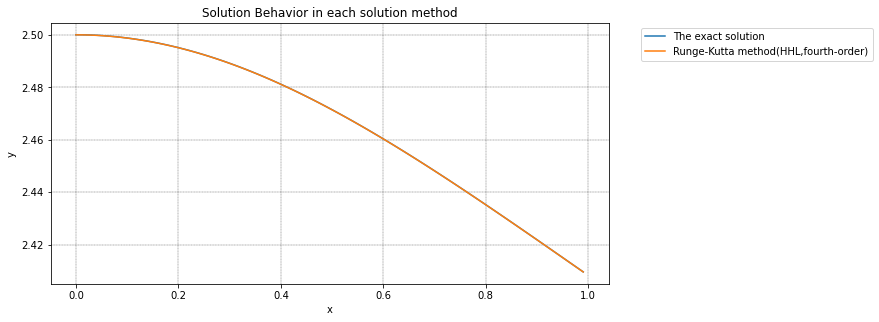

In [5]:
fig = plt.figure(figsize=(10,4.8))
plt.plot(x_list, y_exact, label="The exact solution")  # 厳密解をプロット
plt.plot(x_list, y_HHL_newton, label="Runge-Kutta method(HHL,fourth-order)")  # 4次のルンゲクッタ法(厳密)で求めた近似解をプロット

plt.title("Solution Behavior in each solution method")
plt.grid(color="black", linestyle='--', linewidth=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## ④Newton法による古典計算

In [30]:
def jacobi_newton(x, diff_k_coef_newton):
    jacobi = np.eye(n)
    for i in range(n - 1):
        jacobi[i + 1][i] = -1
        for j in range(1 + order ** 4):
            jacobi[i + 1][i] += -diff_k_coef_newton[i][j] * (x[i] ** j)

    return jacobi


def right_side_newton(x, k_coef_newton):
    formula = np.array([0])
    for i in range(n - 1):
        k_poly = 0
        for j in range(1 + order ** 4):
            k_poly += k_coef_newton[i][j] * (x[i] ** j)

        formula = np.append(formula, -x[i + 1] + x[i] + k_poly)

    return formula


###################### Runge-kutta法(4次・Newton)専用 ######################
# newton_first = copy(y_first)  # 初期条件
# for i in range(1, len(newton_first)):
#     newton_first[i] += random.uniform(e, -e)

newton_first = [y_first[0] for i in range(len(x_list))]  # 初期条件

k_coef_newton = np.zeros((n, 1 + order ** 4))
diff_k_coef_newton = np.zeros((n, 1 + order ** 4))
count = 0
func_value = np.zeros((1 + order, 3))

start = time.time()
for _ in tqdm.tqdm(range(depth)):
    for i in range(n - 1):
        # 関数の値を計算
        for l in range(1 + order):
            for m in range(3):
                func_value[l][m] = function(x_list[i] + m * h / 2)[l]

        k_1 = np.zeros(1 + order ** 4)
        k_2 = np.zeros(1 + order ** 4)
        k_3 = np.zeros(1 + order ** 4)
        k_4 = np.zeros(1 + order ** 4)
        k = np.zeros(1 + order ** 4)

        for l in range(1 + order):
            k_1[l] = h * func_value[l][0]

        k += k_1 / 6.0

        k_1 = k_1 / 2
        k_1[1] += 1
        k_temp = np.zeros(1 + order ** 4)
        k_temp[0] = 1
        for l in range(1 + order):
            k_2 += h * func_value[l][1] * k_temp
            k_temp = times_list(k_1, k_temp)

        k += k_2 / 3.0

        k_2 = k_2 / 2
        k_2[1] += 1
        k_temp = np.zeros(1 + order ** 4)
        k_temp[0] = 1
        for l in range(1 + order):
            k_3 += h * func_value[l][1] * k_temp
            k_temp = times_list(k_2, k_temp)

        k += k_3 / 3.0

        k_3[1] += 1
        k_temp = np.zeros(1 + order ** 4)
        k_temp[0] = 1
        for l in range(1 + order):
            k_4 += h * func_value[l][2] * k_temp
            k_temp = times_list(k_3, k_temp)

        k += k_4 / 6.0
        k_coef_newton[i] = k  # i番目のkを多項式で表示したときの係数
        diff_k_coef_newton[i] = differential(k)  # i番目のdk/dyを多項式で表示したときの係数

    jacobi_matrix_newton = jacobi_newton(newton_first, diff_k_coef_newton)
    right_newton = right_side_newton(newton_first, k_coef_newton)

    Delta = np.linalg.lstsq(jacobi_matrix_newton, right_newton, rcond=0)[0]

    if np.average(np.abs(Delta)) < tol:
        break
    else:
        newton_first += Delta
        count += 1

t = time.time() - start
y_exact_newton = newton_first
print("Newton calculation completed.")
print("Elapsed time[s]:", t)
print("number:", number, "h:", h, " n:", n, " e:", e, " tol:", tol)
print("Number of updates:", count, "\n")

  1%|          | 1/100 [00:00<00:04, 19.98it/s]

Newton calculation completed.
Elapsed time[s]: 0.05405783653259277
number: 0 h: 0.05  n: 100  e: 1  tol: 1e-10
Number of updates: 1 



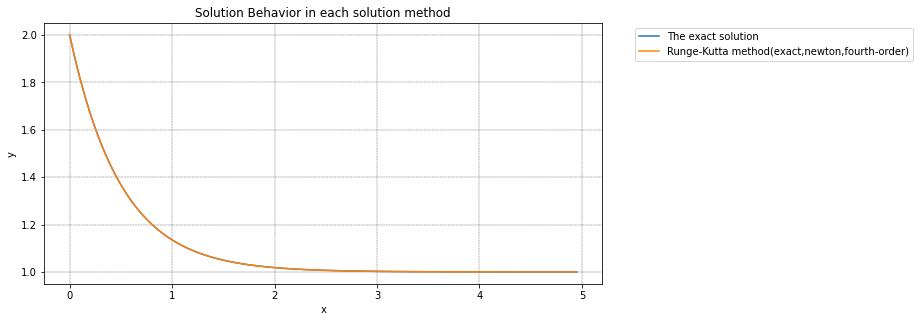

In [31]:
fig = plt.figure(figsize=(10,4.8))
plt.plot(x_list, y_exact, label="The exact solution")  # 厳密解をプロット
plt.plot(x_list, y_exact_newton, label="Runge-Kutta method(exact,newton,fourth-order)")  # 4次のルンゲクッタ法(厳密)で求めた近似解をプロット

plt.title("Solution Behavior in each solution method")
plt.grid(color="black", linestyle='--', linewidth=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## ⑤修正Powell法による古典計算（scipy.optimize.rootによる解法）

In [32]:
###################### Runge-kutta法(4次・hybr)専用 ######################
# hybr_first = copy(y_first)  # 初期条件
# for i in range(1, len(hybr_first)):
#     hybr_first[i] += random.uniform(e, -e)

hybr_first = [y_first[0] for i in range(len(x_list))]  # 初期条件

k_coef_hybr = np.zeros((n, 1 + order ** 4))  # k_coef_hybr = [k(x_0),k(x_1),...,k(x_(n))]
diff_k_coef_hybr = np.zeros((n, 1 + order ** 4))
func_value = np.zeros((1 + order, 3))
start = time.time()

for i in range(n - 1):
    for l in range(1 + order):
        for m in range(3):
            func_value[l][m] = function(x_list[i] + m * h / 2)[l]

    k_1 = np.zeros(1 + order ** 4)
    k_2 = np.zeros(1 + order ** 4)
    k_3 = np.zeros(1 + order ** 4)
    k_4 = np.zeros(1 + order ** 4)
    k = np.zeros(1 + order ** 4)

    # k_1 = h*f(x_i,y_i)
    for l in range(1 + order):
        k_1[l] = h * func_value[l][0]

    k += k_1 / 6.0

    # k_2 = h*f(x_i+h/2,y_i+k_1/2)
    k_1 = k_1 / 2
    k_1[1] += 1
    k_temp = np.zeros(1 + order ** 4)
    k_temp[0] = 1
    for l in range(1 + order):
        k_2 += h * func_value[l][1] * k_temp
        k_temp = times_list(k_1, k_temp)

    k += k_2 / 3.0

    # k_3 = h*f(x_i+h/2,y_i+k_2/2)
    k_2 = k_2 / 2
    k_2[1] += 1
    k_temp = np.zeros(1 + order ** 4)
    k_temp[0] = 1
    for l in range(1 + order):
        k_3 += h * func_value[l][1] * k_temp
        k_temp = times_list(k_2, k_temp)

    k += k_3 / 3.0

    # k_4 = h*f(x_i+h/2,y_i+k_3/2)
    k_3[1] += 1
    k_temp = np.zeros(1 + order ** 4)
    k_temp[0] = 1
    for l in range(1 + order):
        k_4 += h * func_value[l][2] * k_temp
        k_temp = times_list(k_3, k_temp)

    k += k_4 / 6.0
    k_coef_hybr[i] = k  # i番目のkを多項式で表示したときの係数
    diff_k_coef_hybr[i] = differential(k)  # i番目のdk/dyを多項式で表示したときの係数


def jacobi_hybr(x):
    jacobi = np.eye(n)
    for i in range(n - 1):
        jacobi[i + 1][i] = -1
        for j in range(1 + order ** 4):
            jacobi[i + 1][i] += -diff_k_coef_hybr[i][j] * (x[i] ** j)

    return jacobi


def func_hybr(x):
    formula = [x[0] - hybr_first[0]]
    for i in range(n - 1):
        k_poly = 0
        for j in range(1 + order ** 4):
            k_poly += k_coef_hybr[i][j] * (x[i] ** j)

        formula.append(x[i + 1] - x[i] - k_poly)

    return formula


result = optimize.root(func_hybr, hybr_first, jac=jacobi_hybr, method="hybr")
y_exact_hybr = result.x
###################### Runge-kutta法(4次・hybr)専用 ######################
t = time.time() - start
result = optimize.root(func_hybr, hybr_first, jac=jacobi_hybr, method="hybr")
y_exact_hybr = result.x
print("modified powell method calculation completed.")
print("Elapsed time[s]:", t)
print("number:", number, "h:", h, " n:", n, " e:", e, " tol:", tol)

modified powell method calculation completed.
Elapsed time[s]: 0.03542780876159668
number: 0 h: 0.05  n: 100  e: 1  tol: 1e-10


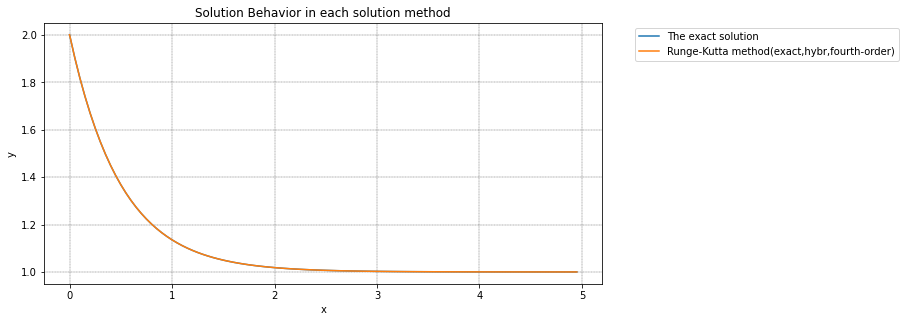

In [33]:
fig = plt.figure(figsize=(10,4.8))
plt.plot(x_list, y_exact, label="The exact solution")  # 厳密解をプロット
plt.plot(x_list, y_exact_hybr, label="Runge-Kutta method(exact,hybr,fourth-order)")  # 4次のルンゲクッタ法(厳密)で求めた近似解をプロット

plt.title("Solution Behavior in each solution method")
plt.grid(color="black", linestyle='--', linewidth=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## ⑥普通のRunge-Kutta法

In [34]:
y_runge4 = np.zeros(len(x_list))  # 初期条件
y_runge4[0] = y_first[0]
for i in range(len(x_list)-1):
    k_1 = 0
    for j in range(1+order):
        k_1 += h*function(x_list[i])[j]*(y_runge4[i]**j)
        
    k_2 = 0
    for j in range(1+order):
        k_2 += h*function(x_list[i]+h/2)[j]*(y_runge4[i]+k_1/2)**j
        
    k_3 = 0
    for j in range(1+order):
        k_3 += h*function(x_list[i]+h/2)[j]*(y_runge4[i]+k_2/2)**j
        
    k_4 = 0
    for j in range(1+order):
        k_4 += h*function(x_list[i]+h)[j]*(y_runge4[i]+k_3)**j
        
    k = (k_1 + 2*k_2 + 2*k_3 + k_4)/6
    
    y_runge4[i+1] = y_runge4[i] + k
    

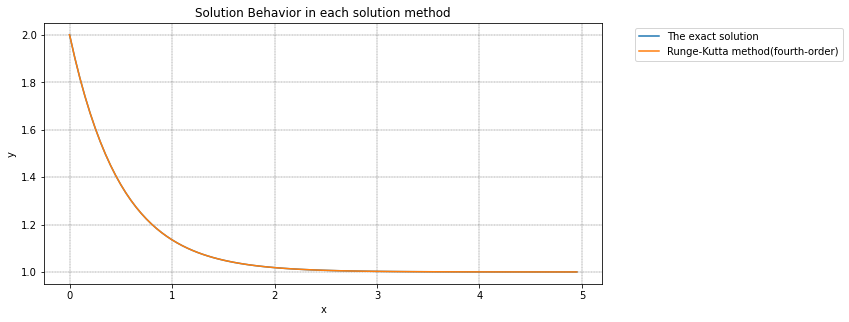

In [35]:
fig = plt.figure(figsize=(10,4.8))
plt.plot(x_list, y_exact, label="The exact solution")  # 厳密解をプロット
plt.plot(x_list, y_runge4, label="Runge-Kutta method(fourth-order)")  # 4次のルンゲクッタ法(厳密)で求めた近似解をプロット

plt.title("Solution Behavior in each solution method")
plt.grid(color="black", linestyle='--', linewidth=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## ⑦それぞれのグラフ・相対誤差

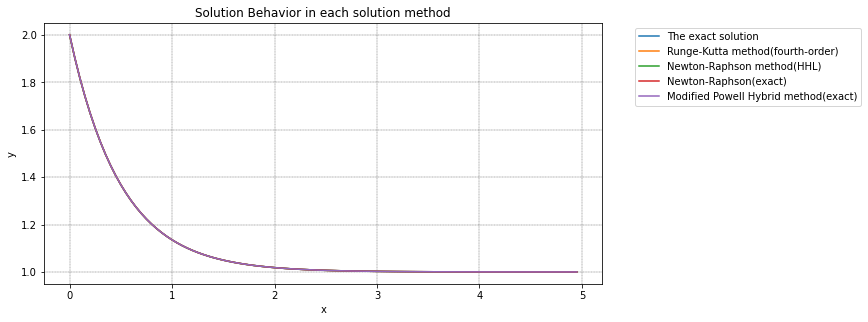

In [36]:
fig = plt.figure(figsize=(10, 4.8))
plt.plot(x_list, y_exact, label="The exact solution")  # 厳密解をプロット
plt.plot(x_list, y_runge4, label="Runge-Kutta method(fourth-order)")  # 4次のルンゲクッタ法(厳密)で求めた近似解をプロット
plt.plot(x_list, y_HHL_newton, label="Newton-Raphson method(HHL)")  # オイラー法(厳密)で求めた近似解をプロット
plt.plot(x_list, y_exact_newton, label="Newton-Raphson(exact)")  # オイラー法(HHL)で求めた近似解をプロット
plt.plot(x_list, y_exact_hybr, label="Modified Powell Hybrid method(exact)")  # 2次のルンゲクッタ法(厳密)で求めた近似解をプロット

plt.title("Solution Behavior in each solution method")
plt.grid(color="black", linestyle='--', linewidth=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xlabel("x")
plt.ylabel("y")
fig.savefig("1階ODE数値結果/plot(number=" + str(number) + ",reg_qubits=" + str(reg_nbit) + ",e=" + str(e) + ",h=" + str(
    h) + ",n=" + str(n) + ",tol=" + str(tol) + ").png", bbox_inches="tight")
plt.show()

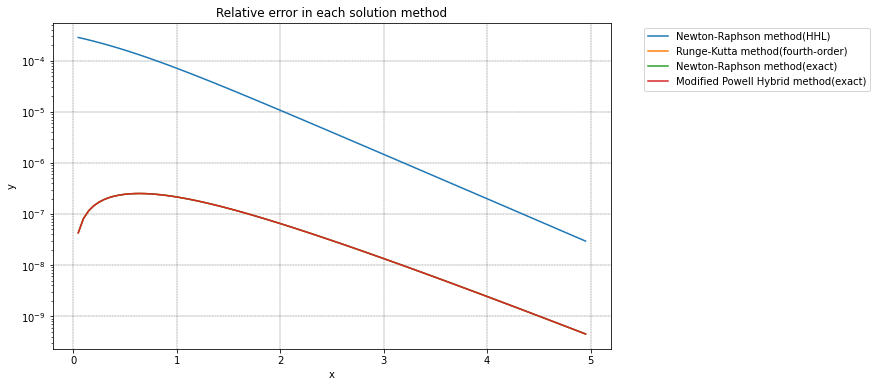

In [37]:
fig = plt.figure(figsize=(10, 6))
plt.plot(x_list[1:], abs((y_HHL_newton - y_exact) / y_exact)[1:], label="Newton-Raphson method(HHL)")  # オイラー法(厳密)で求めた近似解をプロット
plt.plot(x_list[1:], abs((y_runge4 - y_exact) / y_exact)[1:], label="Runge-Kutta method(fourth-order)")  # 4次のルンゲクッタ法(厳密)で求めた近似解をプロット
plt.plot(x_list[1:], abs((y_exact_newton - y_exact) / y_exact)[1:],
         label="Newton-Raphson method(exact)")  # オイラー法(HHL)で求めた近似解をプロット
plt.plot(x_list[1:], abs((y_exact_hybr - y_exact) / y_exact)[1:],
         label="Modified Powell Hybrid method(exact)")  # 2次のルンゲクッタ法(厳密)で求めた近似解をプロット

plt.title("Relative error in each solution method")
plt.grid(color="black", linestyle='--', linewidth=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xlabel("x")
plt.ylabel("y")
plt.yscale("log")
fig.savefig("1階ODE数値結果/error(number=" + str(number) + ",reg_qubits=" + str(reg_nbit) + ",e=" + str(e) + ",h=" + str(
    h) + ",n=" + str(n) + ",tol=" + str(tol) + ").png", bbox_inches="tight")
plt.show()